In [ ]:
# to facilitate uploading of csv files
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Visualizing Dataset

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import np_utils



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import pandas as pd

import os
base_dir_path= '/content/drive/MyDrive/SUTD/50.038 CDS/CDSProject/American' # replace file path to dataset folder here

image_count = {} 
class_types = []

for base, dir, files in os.walk(base_dir_path):
  if base == base_dir_path:
    class_types = dir
class_types.sort()
for i in class_types:
  for base,dir,files in os.walk(f"{base_dir_path}/{i}"):
    totalfiles = 0
    for f in files:
      totalfiles+=1
    image_count[i] = [totalfiles]

In [ ]:
df = pd.DataFrame.from_dict(image_count, orient='index', columns=['Sample_Size'])
print(df)
df.to_csv('path_labels',encoding='utf-8')

   Sample_Size
0         3070
1         1570
2         1570
3         1570
4         3070
5         3070
6         3070
7         3070
8         3070
9         3070
a         6071
b         6070
c         5465
d         6070
e         3070
f         6070
g         6070
h         6070
i         6807
j         6124
k         5488
l         6494
m         2924
n         3968
o         7294
p         2566
q         3590
r         3538
s         2374
t         3076
u         3244
v         3926
w         2086
x         2330
y         2458
z         2218


<Figure size 7200x360 with 0 Axes>

Text(0.5, 0, 'Sample Label')

Text(0, 0.5, 'Sample Size')

Text(0.5, 1.0, 'Sample Distribution')

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, 'a'),
 Text(0, 0, 'b'),
 Text(0, 0, 'c'),
 Text(0, 0, 'd'),
 Text(0, 0, 'e'),
 Text(0, 0, 'f'),
 Text(0, 0, 'g'),
 Text(0, 0, 'h'),
 Text(0, 0, 'i'),
 Text(0, 0, 'j'),
 Text(0, 0, 'k'),
 Text(0, 0, 'l'),
 Text(0, 0, 'm'),
 Text(0, 0, 'n'),
 Text(0, 0, 'o'),
 Text(0, 0, 'p'),
 Text(0, 0, 'q'),
 Text(0, 0, 'r'),
 Text(0, 0, 's'),
 Text(0, 0, 't'),
 Text(0, 0, 'u'),
 Text(0, 0, 'v'),
 Text(0, 0, 'w'),
 Text(0, 0, 'x'),
 Text(0, 0, 'y'),
 Text(0, 0, 'z')]

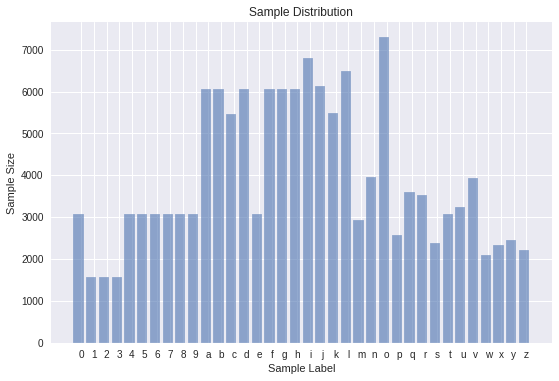

<Figure size 7200x360 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

size = df.Sample_Size
labels = class_types


# Keep a numeric index for the x-axis lables. This will be the positions of the ticks. 
index = np.arange(len(size))

fig, ax = plt.subplots()

# Toy with the below parameters to change the appearance of your graph:
bar_width = 0.8
opacity = 0.6
plt.figure(figsize=(100, 5))
rects1 = ax.bar(index, size, bar_width,
                alpha=opacity)


ax.set_xlabel('Sample Label')
ax.set_ylabel('Sample Size')
ax.set_title('Sample Distribution')

ax.set_xticks(index + bar_width / 4)

ax.set_xticklabels(labels)
plt.savefig("ASLDatasetDistribution.png", dpi=fig.dpi )
plt.show()

#Structuring Dataset

Creating a structured list from our dataset to follow ImageFolder's requirements. 

Dataset is shuffled and collected by a 8:2 ratio to make up 100 images for each category

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import os
from torchvision import transforms
import shutil
import glob

BATCH_SIZE = 3
DATA_LENGTH = 100
NUM_CATEGORIES = 2

base_dir_path= '/content/drive/MyDrive/CDSProject/American'
new_path = '/content/drive/MyDrive/CDSProject/NewAmerican'

new_training = '/content/drive/MyDrive/CDSProject/NewAmerican/train'
new_test = '/content/drive/MyDrive/CDSProject/NewAmerican/test'

#make new directory

if not os.path.exists(new_path):
  
  # Create a new directory because it does not exist 
  os.makedirs(new_path)
  print("The new directory is created!")

if not os.path.exists(new_training):
  
  # Create a new directory because it does not exist 
  os.makedirs(new_training)
  print("The new directory is created!")

if not os.path.exists(new_test):
  
  # Create a new directory because it does not exist 
  os.makedirs(new_test)
  print("The new directory is created!")



data = {}
ones = np.ones((50, 50, 3))

# sort the categories
images = os.listdir(base_dir_path)
images.sort()

# store data from directory into dictionary 
for category in images:
  folder = os.path.join(base_dir_path, category)
  folder_ls = os.listdir(folder)
  random.shuffle(folder_ls)
  arr = []
  count = 0

  inner_path_test = os.path.join(new_test,category)
  inner_path_train = os.path.join(new_training,category)

  if not os.path.exists(inner_path_test):
  # Create a new directory because it does not exist 
    os.makedirs(inner_path_test)
  #print("The new directory is created!")

  if not os.path.exists(inner_path_train):
  # Create a new directory because it does not exist 
    os.makedirs(inner_path_train)
  #print("The new directory is created!")

  for f in folder_ls:
    if count < 80:
        shutil.copy(os.path.join(folder, f), inner_path_train)
    else:
        shutil.copy(os.path.join(folder, f), inner_path_test)


    count += 1
    if count == DATA_LENGTH:
      break

  data[category] = arr

#Training Model

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn

## Data Augmentation

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
transform = transforms.Compose(
    [transforms.Resize((150, 150)),
     transforms.RandomAffine(degrees=(-5,5),translate=(0.1,0.1),shear=(-7,7)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

batch_size = 10

train_data_dir = '/content/drive/MyDrive/SUTD/50.038 CDS/CDSProject/NewAmerican/train'
test_data_dir = '/content/drive/MyDrive/SUTD/50.038 CDS/CDSProject/NewAmerican/test'

train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = datasets.ImageFolder(test_data_dir, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
class_names = train_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

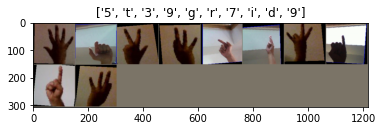

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train and Visualize Methods

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} , actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

In [ ]:
import time


# Train the model
def train(model,dataloader,val_dataloader):
    model.train() #set the mode of the model to train mode
    total_acc, total_count, rep_acc, rep_count = 0, 0, 0, 0
    train_loss, rep_loss=0.0, 0.0
    log_interval = 50
    start_time = time.time() # time the training

    #accuracy
    running_loss = 0.0
    running_corrects = 0

    for i, data in enumerate(dataloader):
        inputs, labels = data
        # make sure the data is on the GPU
        labels=labels.to(device)
        inputs=inputs.to(device)     
        optimizer.zero_grad()

        # forward propagation, i.e. get predictions
        predicted_label = model(inputs)
        pred = torch.argmax(model(inputs),dim=1)
        

        # calculate loss and backpropagate to model paramters:
        loss = criterion(predicted_label, labels) #.squeeze().type(torch.LongTensor)
        train_loss += loss.item() # to be reported per epoch
        rep_loss += loss.item() # to be reported per log_interval batches
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        # update parameters by stepping the optimizer
        optimizer.step()

        # update the total accuracy to be reported per epoch and batch, and keep track of the loop 
        total_acc += (pred == labels).sum().item() # to be reported per epoch
        rep_acc += (pred == labels).sum().item() # to be reported per log_interval batches
        
        total_count += labels.size(0)
        rep_count += labels.size(0)

        

        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train_loss {:8.3f} | accuracy {:8.3f} | elapsed time {:5.1f} seconds'.format(epoch, i, len(dataloader),
                                              rep_loss/log_interval, rep_acc/rep_count, elapsed))
            rep_acc, rep_count = 0, 0
            rep_loss=0.0
            start_time = time.time()


    # Make a pass over the validation data.
    val_acc, val_count = 0.0, 0.0
    cum_loss = 0.0
    model.eval()
    with torch.no_grad():
        for j, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs=inputs.to(device)
            labels = labels.to(device)

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            pred_score = torch.argmax(model(inputs),dim=1)

            cum_loss += criterion(scores, labels).item()

            # Count how many correct in this batch.
            val_acc += (pred_score == labels).sum().item()
            val_count += labels.size(0)


    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Val.Loss: %.4f, Val. Accuracy: %.4f' % 
            (epoch, cum_loss / (j + 1), val_acc/val_count))
    return total_acc/total_count, val_acc/val_count, train_loss/(i+1), cum_loss / (j + 1)
      

## Model, Criterion and Optimizer

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 36)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Training Model with Train Dataset

In [ ]:
# Set optimizer and loss function (criterion)
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(50):
  train_acc, val_acc, train_loss, val_loss=train(model_ft,train_dataloader,val_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

| epoch   0 |    50/  288 batches | train_loss    3.982 | accuracy    0.025 | elapsed time  77.5 seconds
| epoch   0 |   100/  288 batches | train_loss    3.859 | accuracy    0.016 | elapsed time  17.1 seconds
| epoch   0 |   150/  288 batches | train_loss    3.775 | accuracy    0.036 | elapsed time  18.0 seconds
| epoch   0 |   200/  288 batches | train_loss    3.750 | accuracy    0.010 | elapsed time  17.4 seconds
| epoch   0 |   250/  288 batches | train_loss    3.743 | accuracy    0.028 | elapsed time  16.8 seconds
Validation-epoch 0. Avg-Val.Loss: 3.7659, Val. Accuracy: 0.0333
| epoch   1 |    50/  288 batches | train_loss    3.832 | accuracy    0.025 | elapsed time   5.7 seconds
| epoch   1 |   100/  288 batches | train_loss    3.695 | accuracy    0.022 | elapsed time   5.4 seconds
| epoch   1 |   150/  288 batches | train_loss    3.708 | accuracy    0.034 | elapsed time   5.4 seconds
| epoch   1 |   200/  288 batches | train_loss    3.682 | accuracy    0.038 | elapsed time   5.4

In [ ]:
# save the model
torch.save(model_ft.state_dict(), 'bestaslmodel.pt')

## Visualize Model

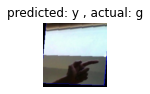

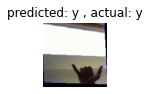

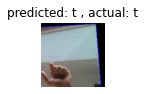

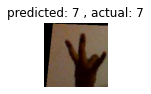

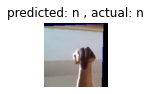

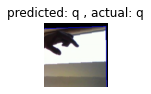

In [ ]:
visualize_model(model_ft)

## Plotting Results

In [ ]:
#plotting the accuracies gathered from the epochs
def plotAccuracy(): 
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,va,linewidth=3)
    plt.legend(('Train_acc','Val_acc'))

    # make the graph understandable: 
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.savefig("accuracy_graph")
    plt.show()

def plotLoss(): 
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,tl,epovec,vl,linewidth=3)
    plt.legend(('Train_loss','Val_loss'))

    # make the graph understandable: 
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.savefig("loss_graph")
    plt.show()

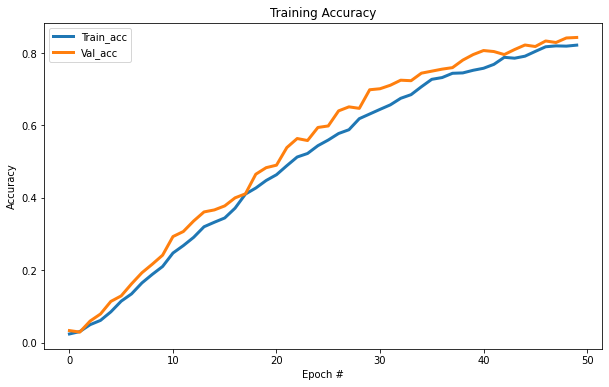

In [ ]:
plotAccuracy()

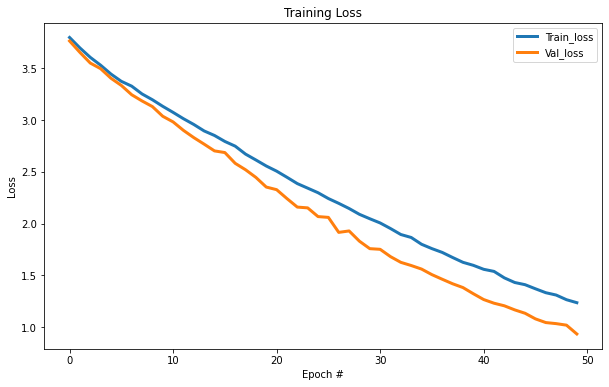

In [ ]:
plotLoss()

## Confusion Matrix

In [ ]:
def get_confusion_matrix(model):

    confusion_matrix = np.zeros((36, 36))

    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(len(preds)):
              confusion_matrix[int(preds[j])][int(labels[j])] = confusion_matrix[int(preds[j])][int(labels[j])] + 1

        return confusion_matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    print('Confusion Matrix')
    print(cm)

    plt.figure(figsize=(20, 20), dpi = 80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)
    plt.tight_layout()

    # plt.savefig("conf_matrix")

In [ ]:
confusion_matrix = get_confusion_matrix(model_ft)
confusion_matrix_list = confusion_matrix.tolist()

for j in range(len(confusion_matrix_list)):
  confusion_matrix_list[j] = [int(i) for i in confusion_matrix_list[j]]
  print(confusion_matrix_list[j])

[19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 17, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 3, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 2, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 

Confusion Matrix
[[19  0  0 ...  0  0  0]
 [ 0 19  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  0]
 ...
 [ 0  0  0 ... 17  0  0]
 [ 0  0  0 ...  0 19  0]
 [ 0  0  0 ...  0  0 20]]


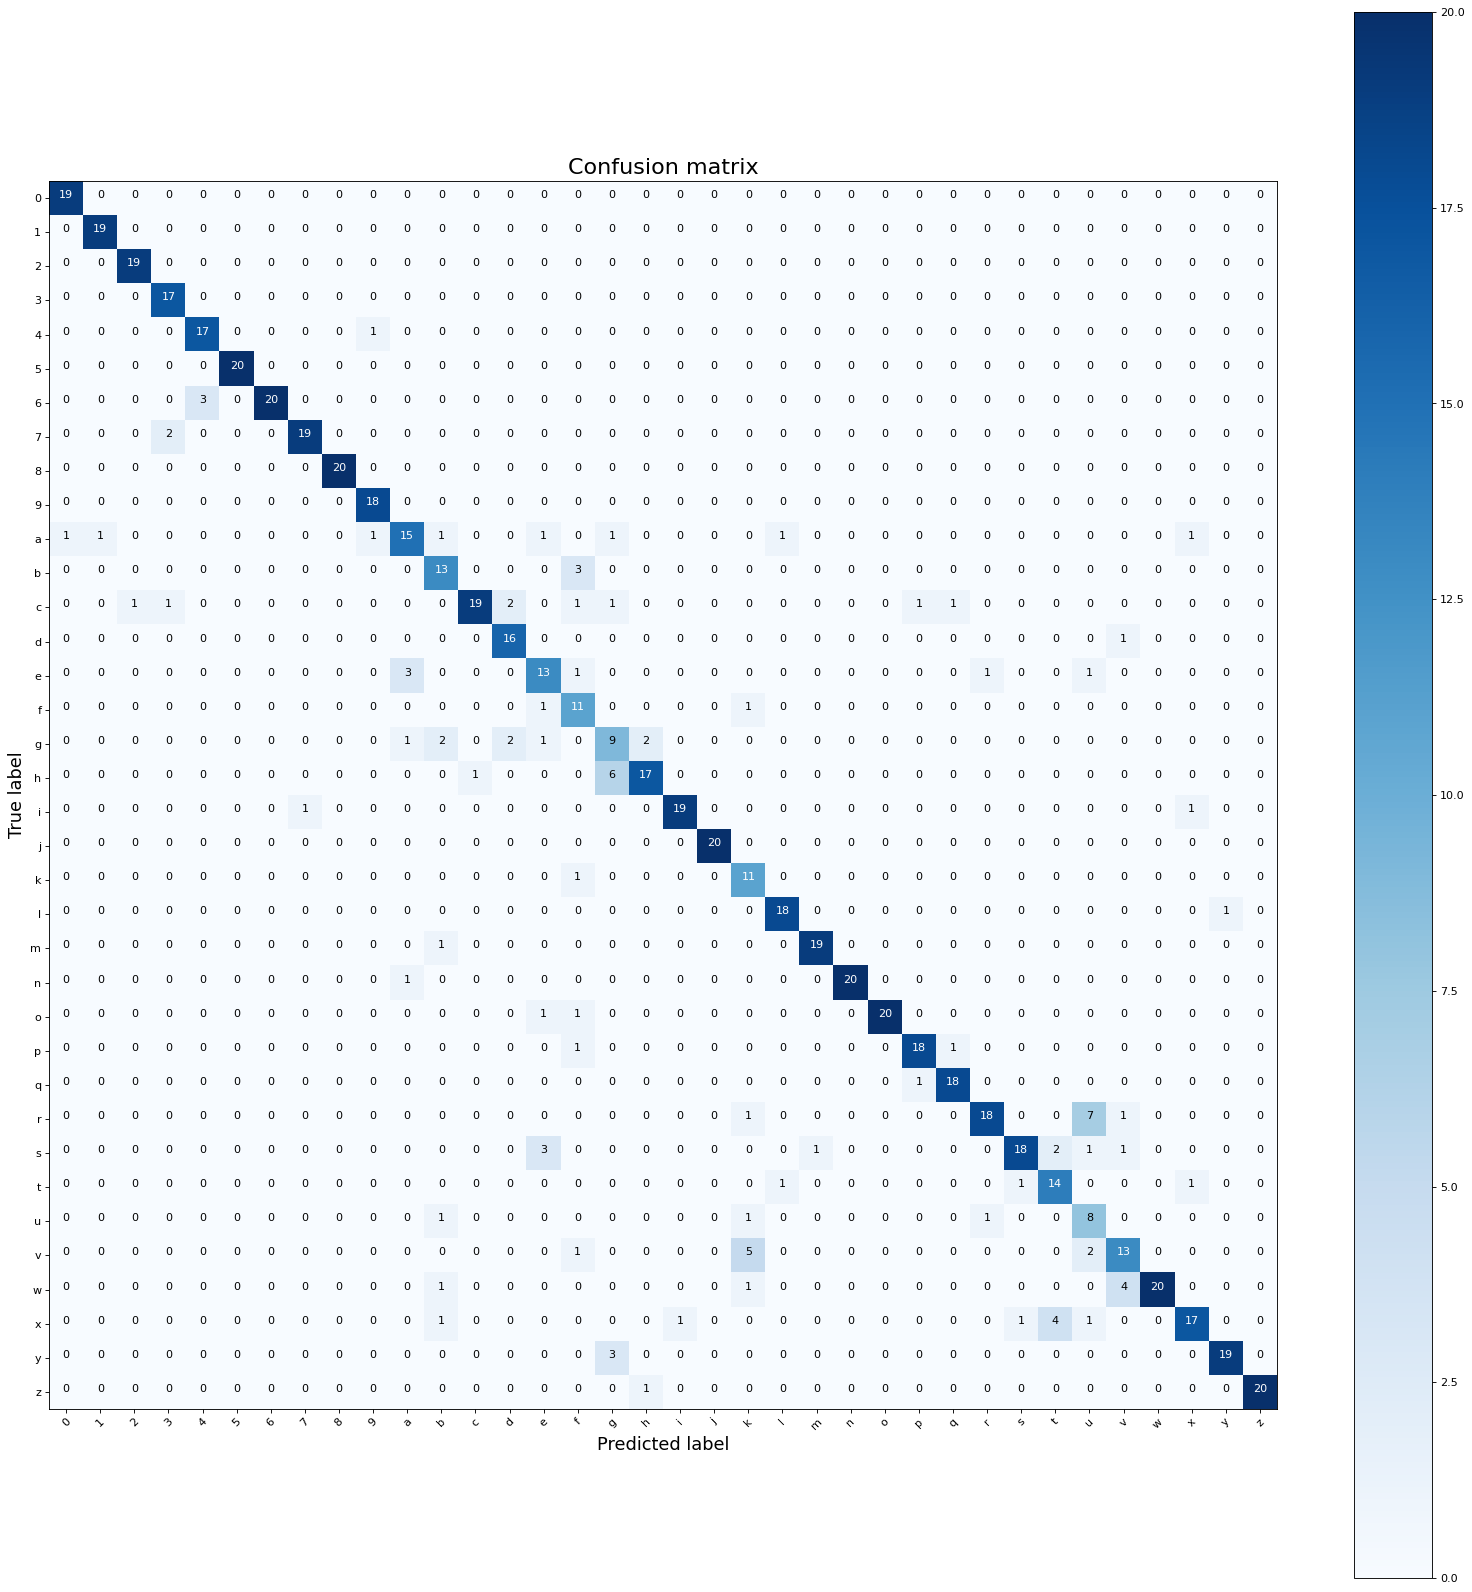

In [ ]:
plot_confusion_matrix(np.array(confusion_matrix_list), classes=class_names,
                      title='Confusion matrix')

# Testing Model

In [ ]:
import glob
from PIL import Image
import random

#open random image from validation dataset
twoclassimagepath=glob.glob('/content/drive/MyDrive/SUTD Term 6 (DB ML CDS HASS)/CDSProject/NewAmerican/test/2/*.jpg')

randomint=random.randint(0,len(twoclassimagepath)-1)
item = twoclassimagepath[randomint]

im = Image.open(item)
testimg = transform(im)
imshow(testimg.cpu())

testimg=testimg[None,:].to(device)
 #trick to add one more dimension (batch dimension)

model_ft.eval()

outputs = model_ft(testimg)
x, preds = torch.max(outputs, 1)
print(x.item())
print(preds.item())

for j in range(outputs.size()[0]):
    print('predicted: {}'.format(class_names[preds[j]] ))